In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import Xception ,  VGG19,EfficientNetB7, DenseNet201, ResNet50
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import os
import pandas as pd

data_dir = r"/content/drive/MyDrive/CSE438_lung/lung_image_sets"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)


df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


print(df)


                                               filepaths    labels
0      /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_aca
1      /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_aca
2      /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_aca
3      /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_aca
4      /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_aca
...                                                  ...       ...
14995  /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_scc
14996  /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_scc
14997  /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_scc
14998  /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_scc
14999  /content/drive/MyDrive/CSE438_lung/lung_image_...  lung_scc

[15000 rows x 2 columns]


In [ ]:
labels = df['labels']
train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=labels)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=temp_df['labels'])

In [ ]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [ ]:
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)
class_count = len(list(train_gen.class_indices.keys()))


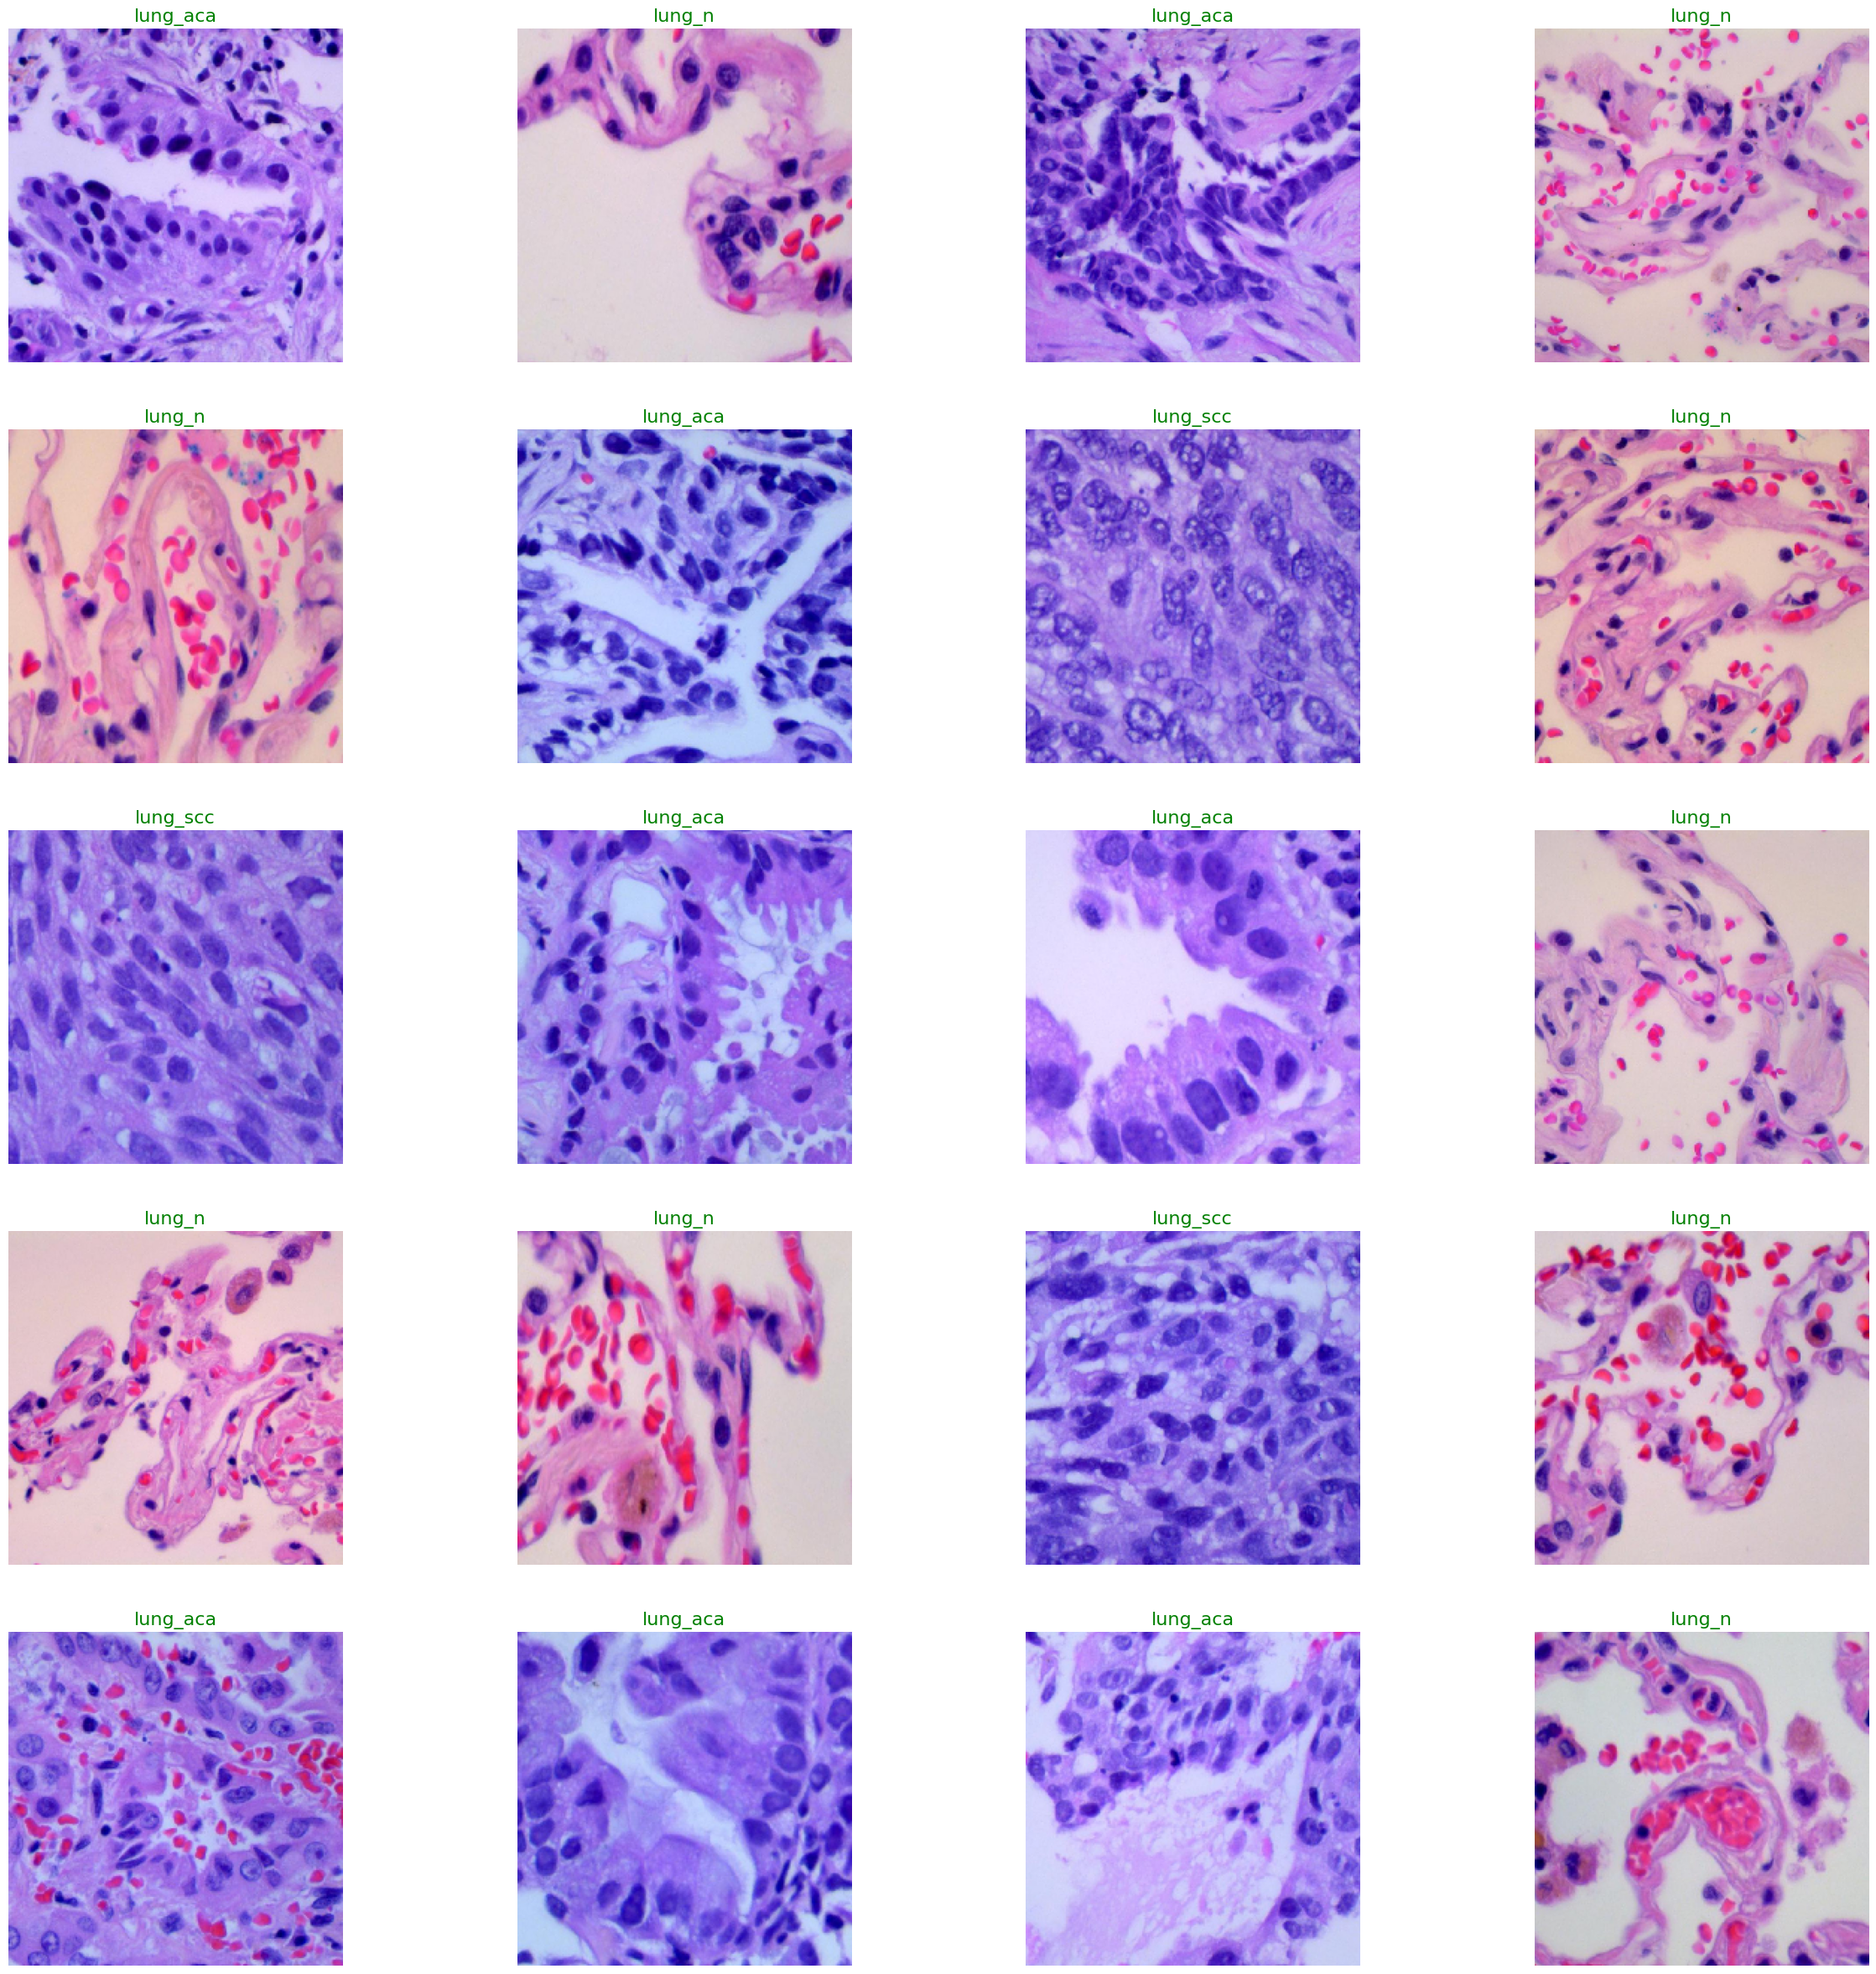

In [ ]:
plt.figure(figsize=(30, 30))

for i in range(20):

    plt.subplot(5, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    index = np.argmax(labels[i])

    class_name = classes[index]

    plt.title(class_name, color='green', fontsize=16)

    plt.axis('off')

plt.show()

In [ ]:
def get_callbacks(model_name):
    callbacks = []


    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max')
    callbacks.append(checkpoint)


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)


    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)

    return callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
base_model = VGG19(input_shape=img_shape, include_top=False, weights='imagenet')

base_model.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.3)(x)
y = Dense(512, activation='relu')(x)

y = Dropout(0.3)(y)

predictions = Dense(class_count, activation='softmax', name='final')(y)

model_VGG19 = Model(inputs=base_model.input, outputs=predictions)


model_VGG19.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
epochs=10

callbacks=get_callbacks('VGG19')
history_VGG19=model_VGG19.fit(train_gen,
                                    epochs=epochs,
                                    validation_data=valid_gen,
                                    callbacks=[callbacks])

Epoch 1/10
375/375 [==============================] - ETA: 0s - loss: 1.2520 - accuracy: 0.4284 
Epoch 1: saving model to model.VGG19.h5
375/375 [==============================] - 13126s 35s/step - loss: 1.2520 - accuracy: 0.4284 - val_loss: 0.7522 - val_accuracy: 0.6287 - lr: 0.0010
Epoch 2/10
375/375 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.6831
Epoch 2: saving model to model.VGG19.h5
375/375 [==============================] - 178s 475ms/step - loss: 0.6284 - accuracy: 0.6831 - val_loss: 0.5425 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.7851
Epoch 3: saving model to model.VGG19.h5
375/375 [==============================] - 179s 476ms/step - loss: 0.4931 - accuracy: 0.7851 - val_loss: 0.3447 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 4/10
375/375 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8963
Epoch 4: saving model to model.VGG19.h5
375/375 [==

In [ ]:
ts_length = len(test_df)

test_batch_size = min(32, ts_length)
test_steps = ts_length // test_batch_size

train_score = model_VGG19.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model_VGG19.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model_VGG19.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

46/46 [==============================] - 1465s 33s/step - loss: 0.0546 - accuracy: 0.9851
Train Loss:  0.044704411178827286
Train Accuracy:  0.9816576242446899
--------------------
Valid Loss:  0.07047946751117706
Valid Accuracy:  0.97826087474823
--------------------
Test Loss:  0.054596129804849625
Test Accuracy:  0.9850543737411499


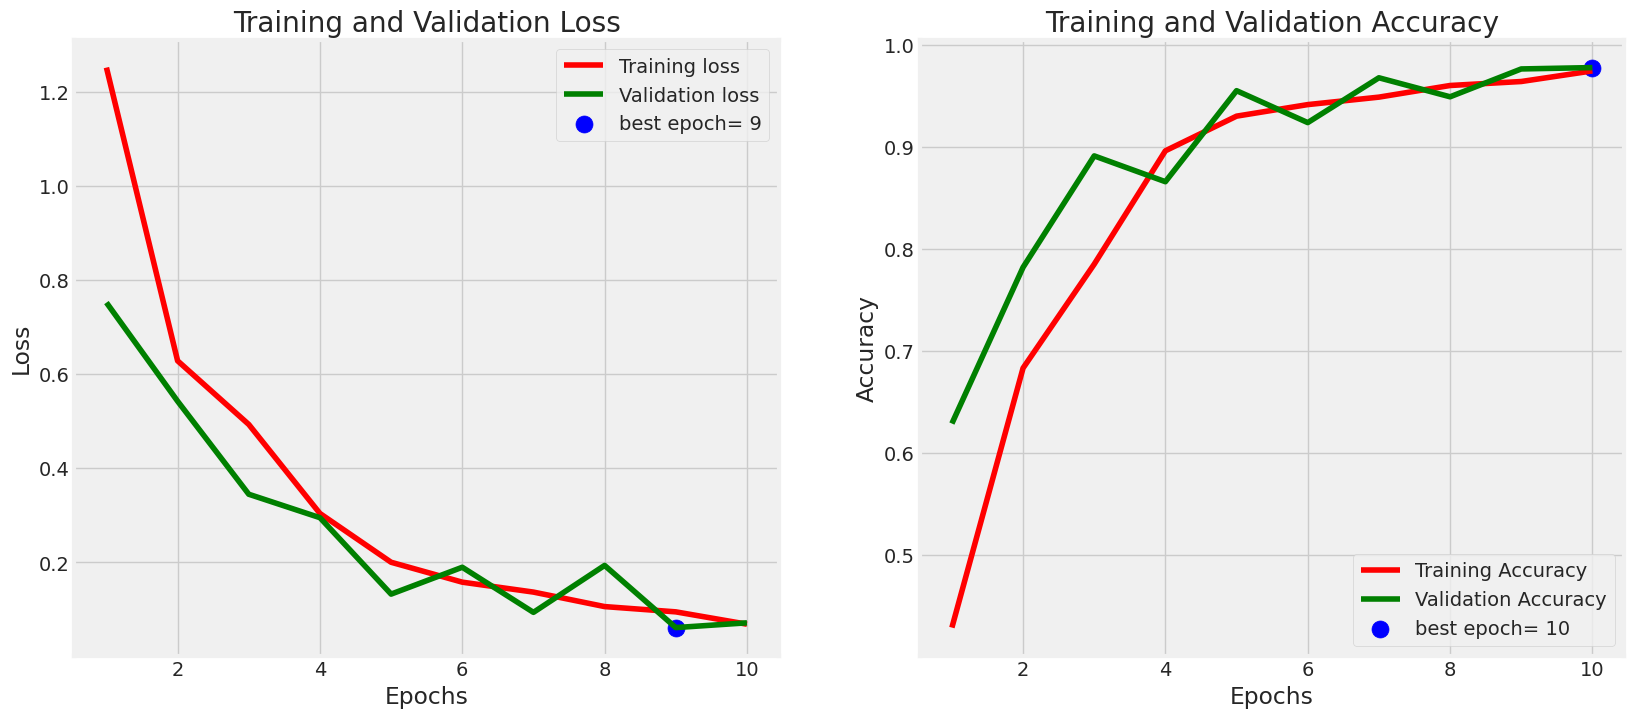

In [ ]:
tr_acc = history_VGG19.history['accuracy']
tr_loss = history_VGG19.history['loss']
val_acc = history_VGG19.history['val_accuracy']
val_loss = history_VGG19.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
preds = model_VGG19.predict_generator(test_gen)
y_pred_VGG19 = np.argmax(preds, axis=1)

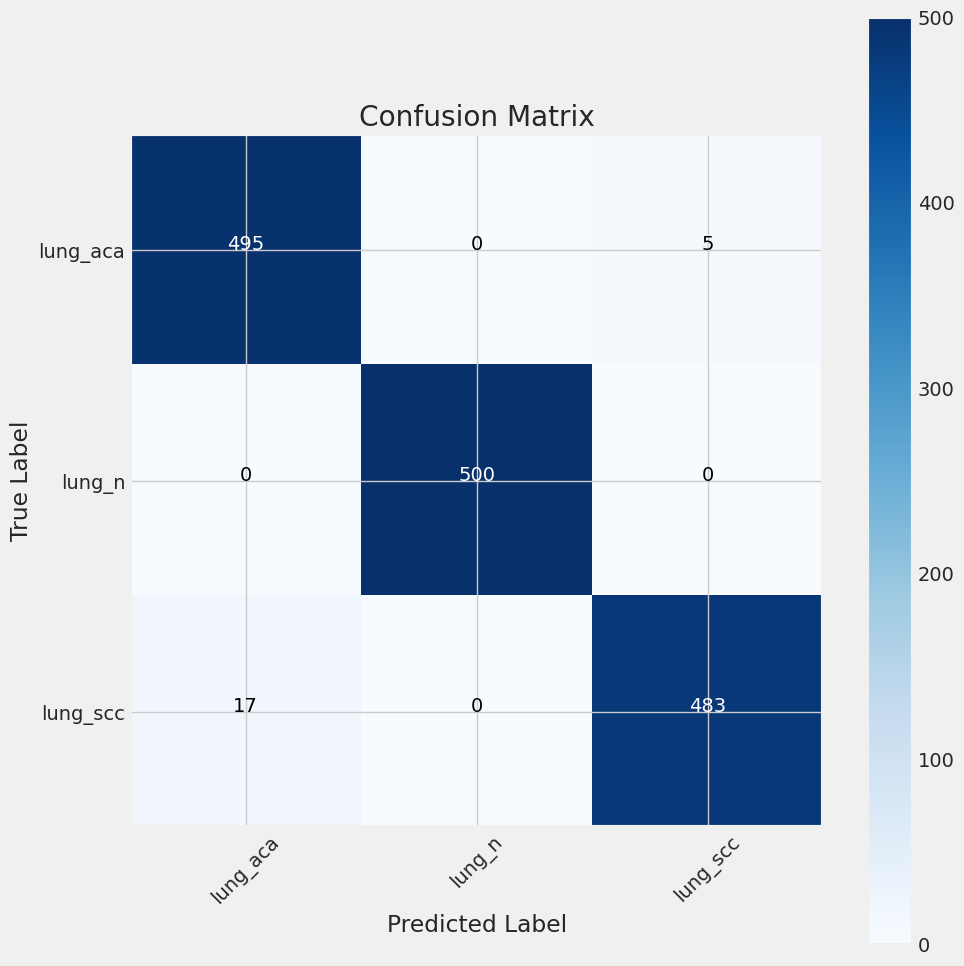

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


cm = confusion_matrix(test_gen.classes, y_pred_VGG19)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred_VGG19, target_names= classes))

              precision    recall  f1-score   support

    lung_aca       0.97      0.99      0.98       500
      lung_n       1.00      1.00      1.00       500
    lung_scc       0.99      0.97      0.98       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500

